## Sarimax Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pytrends
from pytrends.request import TrendReq
import seaborn as sns
import numpy as np

In [2]:
#NP EDA

import calendar 

np_df = pd.read_csv('NPS_with_trends.csv', index_col = 0)

# add month as col
np_df['MonthName'] = np_df['Month'].apply(lambda x: calendar.month_abbr[x])

# add date col
np_df['date'] = pd.to_datetime((np_df.Year*10000+np_df.Month*100+1).apply(str),format='%Y%m%d')
np_df

,ParkName,UnitCode,ParkType,Region,State,Year,Month,RecreationVisits,NonRecreationVisits,RecreationHours,...,ConcessionerLodgingTotal,ConcessionerCampingTotal,TentCampersTotal,RVCampersTotal,BackcountryTotal,NonRecreationOvernightStaysTotal,MiscellaneousOvernightStaysTotal,Google_Searches,MonthName,date
0,Acadia National Park,ACAD,National Park,Northeast,ME,2005,1,10810,600,71346,...,0,0,85815,19302,1157,0,5378,30,Jan,2005-01-01
1,Acadia National Park,ACAD,National Park,Northeast,ME,2005,2,11831,600,78086,...,0,0,85815,19302,1157,0,5378,30,Feb,2005-02-01
2,Acadia National Park,ACAD,National Park,Northeast,ME,2005,3,18917,600,124854,...,0,0,85815,19302,1157,0,5378,28,Mar,2005-03-01
3,Acadia National Park,ACAD,National Park,Northeast,ME,2005,4,59773,600,346683,...,0,0,85815,19302,1157,0,5378,44,Apr,2005-04-01
4,Acadia National Park,ACAD,National Park,Northeast,ME,2005,5,110330,7500,628052,...,0,0,85815,19302,1157,0,5378,58,May,2005-05-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12834,Zion National Park,ZION,National Park,Intermountain,UT,2021,8,466928,1860,3105093,...,55454,0,138730,89919,15071,0,7969,54,Aug,2021-08-01
12835,Zion National Park,ZION,National Park,Intermountain,UT,2021,9,483180,1800,3076210,...,55454,0,138730,89919,15071,0,7969,58,Sep,2021-09-01
12836,Zion National Park,ZION,National Park,Intermountain,UT,2021,10,469379,1860,2902495,...,55454,0,138730,89919,15071,0,7969,51,Oct,2021-10-01
12837,Zion National Park,ZION,National Park,Intermountain,UT,2021,11,308560,1800,1932994,...,55454,0,138730,89919,15071,0,7969,44,Nov,2021-11-01


In [3]:
park_name = 'Arches National Park'
park_df = np_df[np_df['ParkName'] == park_name][['date','Month', 'Year','RecreationVisits','Google_Searches']]


park_df.index = park_df.date
park_df_arima = park_df[['RecreationVisits']]
park_df_arima

,RecreationVisits
date,
2005-01-01,9894
2005-02-01,16168
2005-03-01,62843
2005-04-01,71709
2005-05-01,111718
...,...
2021-08-01,167686
2021-09-01,193002
2021-10-01,169983


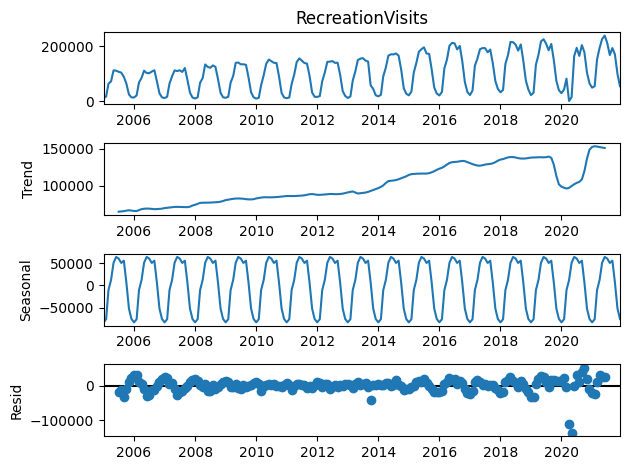

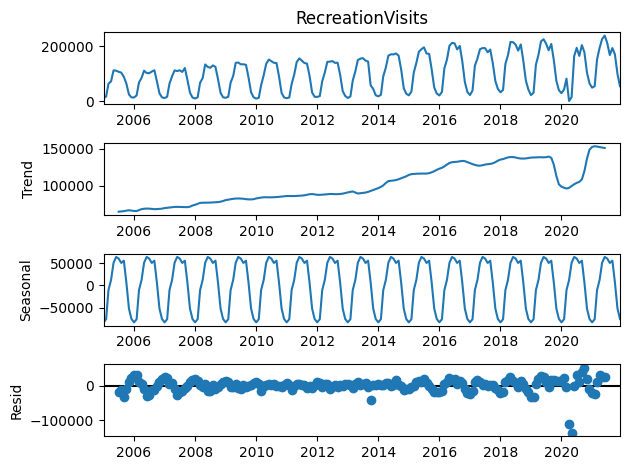

In [4]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp_data = seasonal_decompose(park_df_arima['RecreationVisits'])
decomp_data.plot()

/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Text(0, 0.5, 'Correlation')

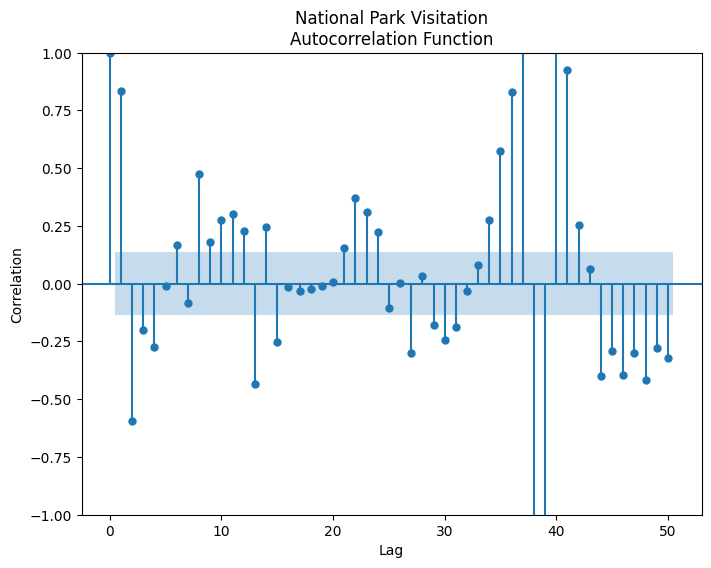

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf

fig, ax = plt.subplots(1, 1, figsize=(8, 6))

plot_pacf(park_df_arima['RecreationVisits'], ax, lags=50, title="National Park Visitation\nAutocorrelation Function")
ax.set_xlabel("Lag")
ax.set_ylabel("Correlation")

In [6]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
# seasonal_order = (Seasonal AR specification, Seasonal Integration order, Seasonal MA, Seasonal periodicity) 
# cycle length = 12 months

parks = ['Yosemite National Park', 'Grand Canyon National Park', 'Great Smoky Mountains National Park', 'Hawaii Volcanoes National Park']

# sarimax function
def getTimeSeries(park_name):
    park_df = np_df[np_df['ParkName'] == park_name][['date','Month', 'Year','RecreationVisits','Google_Searches']]

    park_df.index = park_df.date
    park_df_arima = park_df[['RecreationVisits']]

    model = SARIMAX(park_df_arima['RecreationVisits'], order = (1,0,1),
                                    seasonal_order = (1,0,1,12))
    results = model.fit(disp=0)

    # dynamic = True: out-of-sample prediction, = False: in-sample prediction
    forecasts = results.predict(start = len(park_df_arima)-12, end = len(park_df_arima) + 24, dynamic = False)

    from sklearn import metrics
    from sklearn.metrics import mean_absolute_error
    preds = results.predict(start = 0, end = len(park_df_arima)-1, dynamic = False)

    # in-sample makes better preds
    rmse = np.sqrt(metrics.mean_squared_error(park_df_arima['RecreationVisits'], preds))
    
    return (park_df_arima, forecasts, round(rmse, 3))

/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_mod

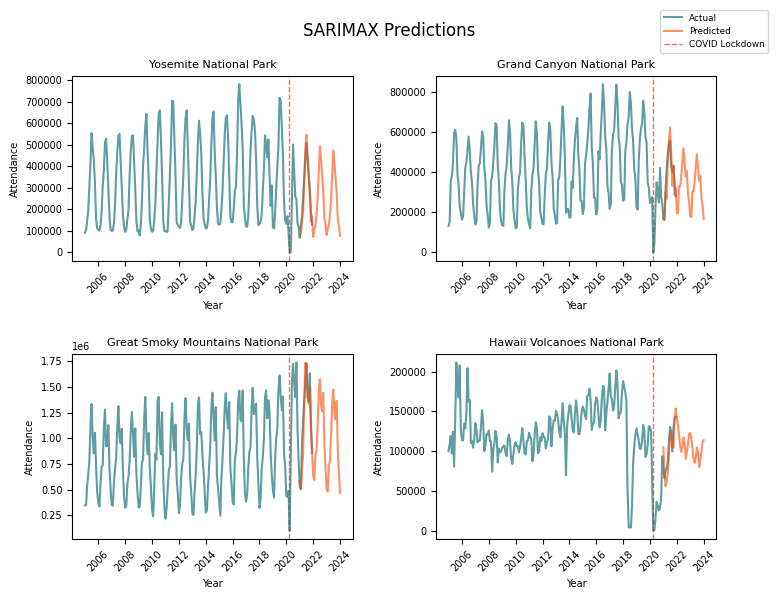

In [7]:
# plotting predictions for 4 NPs
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8,6))

axs[0,0].plot(getTimeSeries(parks[0])[0].index,getTimeSeries(parks[0])[0]['RecreationVisits'], c = 'cadetblue')
axs[0,0].plot(getTimeSeries(parks[0])[1].index, getTimeSeries(parks[0])[1].values, c = 'orangered', alpha = 0.6)
axs[0,0].set_title('{}'.format(parks[0]), size = 8)
axs[0,0].set_xlabel('Year',fontsize = 7) 
axs[0,0].set_ylabel('Attendance', fontsize = 7)
axs[0,0].tick_params(axis='both', labelsize=7)
axs[0,0].tick_params(axis='x', rotation = 45)
axs[0,0].axvline(x=datetime.datetime(2020,3,15), c = 'red', label = 'COVID Lockdown', ls = '--', alpha = 0.6).set_linewidth(1)


axs[0,1].plot(getTimeSeries(parks[1])[0].index,getTimeSeries(parks[1])[0]['RecreationVisits'], c = 'cadetblue')
axs[0,1].plot(getTimeSeries(parks[1])[1].index, getTimeSeries(parks[1])[1].values, c = 'orangered', alpha = 0.6)
axs[0,1].set_title('{}'.format(parks[1]), size = 8)
axs[0,1].set_xlabel('Year' , fontsize = 7) 
axs[0,1].set_ylabel('Attendance', fontsize = 7)
axs[0,1].tick_params(axis='both', labelsize=7)
axs[0,1].tick_params(axis='x', rotation = 45)
axs[0,1].axvline(x=datetime.datetime(2020,3,15), c = 'red', label = 'COVID Lockdown', alpha = 0.6, ls = '--').set_linewidth(1)
axs[0,1].legend(['Actual', 'Predicted', 'COVID Lockdown'], loc=1, prop={'size': 6.4}, bbox_to_anchor=(1.2, 1.38))

axs[1,0].plot(getTimeSeries(parks[2])[0].index,getTimeSeries(parks[2])[0]['RecreationVisits'], c = 'cadetblue')
axs[1,0].plot(getTimeSeries(parks[2])[1].index, getTimeSeries(parks[2])[1].values, c = 'orangered', alpha = 0.6)
axs[1,0].set_title('{}'.format(parks[2]), size = 8)
axs[1,0].set_xlabel('Year', fontsize = 7) 
axs[1,0].set_ylabel('Attendance', fontsize = 7)
axs[1,0].tick_params(axis='both', labelsize=7)
axs[1,0].tick_params(axis='x', rotation = 45)
axs[1,0].yaxis.get_offset_text().set_fontsize(7)
axs[1,0].axvline(x=datetime.datetime(2020,3,15), c = 'red', label = 'COVID Lockdown', alpha = 0.6, ls = '--').set_linewidth(1)

axs[1,1].plot(getTimeSeries(parks[3])[0].index,getTimeSeries(parks[3])[0]['RecreationVisits'], c = 'cadetblue')
axs[1,1].plot(getTimeSeries(parks[3])[1].index, getTimeSeries(parks[3])[1].values, c = 'orangered', alpha = 0.6)
axs[1,1].set_title('{}'.format(parks[3]), size = 8)
axs[1,1].set_xlabel('Year',fontsize = 7) 
axs[1,1].set_ylabel('Attendance',fontsize = 7)
axs[1,1].tick_params(axis='both', labelsize=7)
axs[1,1].tick_params(axis='x', rotation = 45)
axs[1,1].axvline(x=datetime.datetime(2020,3,15), c = 'red', label = 'COVID Lockdown', alpha = 0.6, ls = '--').set_linewidth(1)

fig.tight_layout(pad=1.5)
plt.suptitle('SARIMAX Predictions')
fig.subplots_adjust(top=0.89)
#plt.savefig('sarimax.jpg')

/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


3287595

In [35]:
# calc rmse for each park

rmses =[]
normalized_rmses = []
for p in parks:
    r = getTimeSeries(p)[2]

    ts = getTimeSeries(p)[0].reset_index()
    ts['year'] = ts['date'].dt.year
    attend_21= ts[ts['year'] == 2021]['RecreationVisits'].sum()
    rmses.append(r)
    normalized_rmses.append(r/attend_21)

rmse_df = pd.DataFrame()
rmse_df['Park'] = parks
rmse_df['RMSE'] = rmses
rmse_df['RMSE_normalized'] = normalized_rmses
rmse_df['Total Attendance (2021)'] = [rmses[i]/normalized_rmses[i] for i in range(len(rmse_df))]
rmse_df



/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/lindseyching/Library/Python/3.8/lib/python/site-packages/statsmodels/tsa/base/tsa_mod

,Park,RMSE,RMSE_normalized,Total Attendance (2021)
0,Yosemite National Park,53290.808,0.016210,3287595.0
1,Grand Canyon National Park,59738.817,0.013180,4532677.0
2,Great Smoky Mountains National Park,132248.397,0.009339,14161548.0
3,Hawaii Volcanoes National Park,22332.004,0.017685,1262747.0


In [36]:
import seaborn as sns
cm = sns.light_palette('seagreen', as_cmap=True)
styled = rmse_df.style.background_gradient(cmap = cm)
styled

,Park,RMSE,RMSE_normalized,Total Attendance (2021)
0,Yosemite National Park,53290.808000,0.016210,3287595.000000
1,Grand Canyon National Park,59738.817000,0.013180,4532677.000000
2,Great Smoky Mountains National Park,132248.397000,0.009339,14161548.000000
3,Hawaii Volcanoes National Park,22332.004000,0.017685,1262747.000000
